In [4]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 104.7/104.7 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 64.9/64.9 kB ? eta 0:00:00
     -------------------------------------- 112.2/112.2 kB 6.8 MB/s eta 0:00:00
     ------------------------------------- 948.2/948.2 kB 12.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     -------------------------------------- 508.0/508.0 kB 6.4 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=139012 sha256=8f8e6c2df83fd8abf5230a92a76e7cb6f969f57fd404ff6d74060e11c0b736f8
  Stored in directory: c:\users\yadav\appdata\l

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
anaconda-project 0.11.1 requires ruamel-yaml, which is not installed.
pandas-profiling 3.5.0 requires requests<2.29,>=2.24.0, but you have requests 2.32.3 which is incompatible.
conda-repo-cli 1.0.41 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.41 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.41 requires requests==2.28.1, but you have requests 2.32.3 which is incompatible.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)



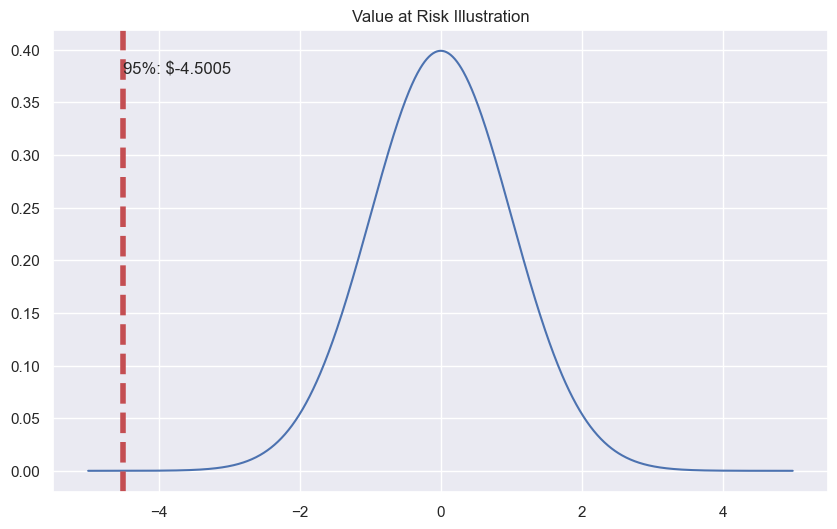

In [6]:
mean = 0
std_dev = 1

x = np.arange(-5, 5, 0.01)

# Calculate the probability density function (PDF) of the normal distribution
y = norm.pdf(x, mean, std_dev)

# Plot the PDF
pdf = plt.plot(x, y)

# Get the current y-axis limits
min_ylim, max_ylim = plt.ylim()

# Display the 95th percentile value on the plot
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%: ${:.4f}'.format(np.percentile(x, 5)))

# Add a vertical dashed line at the 5th percentile position
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed', linewidth=4)

plt.title('Value at Risk Illustration')

plt.show()


In [7]:
def get_daily_data(symbol, start_date, end_date):
    try:
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date)
        if data.empty:
            raise ValueError(f"No data available for {symbol} within the specified date range.")
        return data[['Close']].rename(columns={'Close': 'close'})
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return pd.DataFrame()

symbols = ["IBM", "MSFT", "INTC"]
start_date = '2023-01-01'
end_date = '2023-12-31'

stock_data = []

for symbol in symbols:
    stock_data.append(get_daily_data(symbol, start_date, end_date)['close'])

stocks = pd.DataFrame(stock_data).T
stocks.columns = symbols

# Convert index to datetime if it's not already in datetime format
stocks.index = pd.to_datetime(stocks.index)

# Extract just the date part from the index
stocks.index = stocks.index.date

stocks.head()


,IBM,MSFT,INTC
2023-01-03,131.173401,236.183517,25.775143
2023-01-04,132.146454,225.852097,26.691208
2023-01-05,130.765656,219.158356,26.575495
2023-01-06,133.165787,221.741211,27.703701
2023-01-09,133.026779,223.900162,28.262983


In [8]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns


,IBM,MSFT,INTC
2023-01-04,0.007391,-0.044729,0.034924
2023-01-05,-0.010504,-0.030086,-0.004345
2023-01-06,0.018188,0.011716,0.041576
2023-01-09,-0.001044,0.009689,0.019987
2023-01-10,0.008670,0.007588,0.004426
...,...,...,...
2023-12-22,0.008423,0.002780,0.019353
2023-12-26,0.006578,0.000214,0.050772
2023-12-27,0.001531,-0.001576,0.005135
2023-12-28,0.001773,0.003229,-0.007316


In [9]:
stocks_returns_mean = stocks_returns.mean()
weights = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))
initial_investment = 1e6
conf_level = 0.95
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        # Calculate Parametric VaR for each stock
        VaR_param = (initial_investment - initial_investment * (1 + alpha))[j]
        # Print the Parametric VaR result for each stock
        print("Parametric VaR result for {} is {:.2f}".format(i, VaR_param))
    
    # Calculate Parametric VaR for the entire portfolio
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    # Print a separator line
    print('--' * 25)
    
    return VaR_param


In [10]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param


Parametric VaR result for IBM is 25479.59
Parametric VaR result for MSFT is 24408.51
Parametric VaR result for INTC is 23626.74
--------------------------------------------------


array([25479.58827482, 24408.50795694, 23626.74077198])

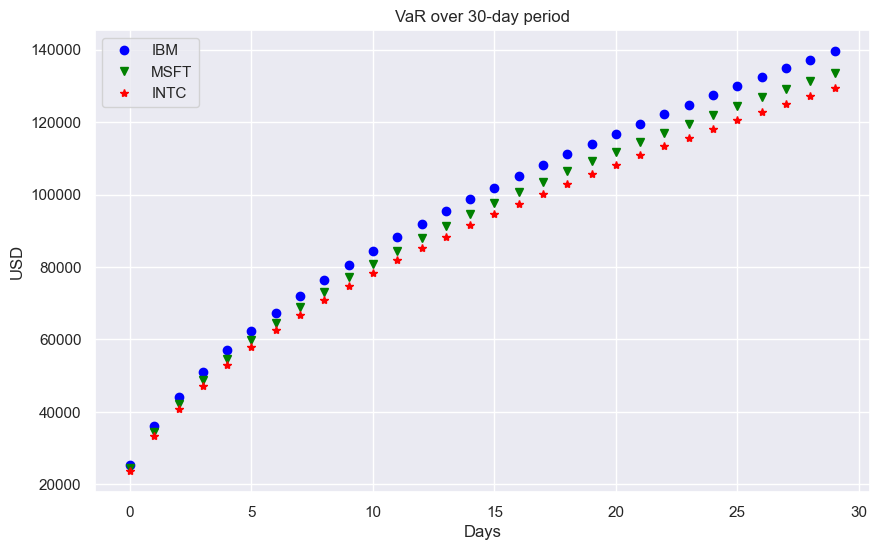

In [17]:
#VaR changes depending on the time horizon in the sense that holding assets for a longer period makes an investor more susceptible to risk.¶

var_horizon = []  # Initialize an empty list to store VaR values over time
time_horizon = 30  # Define the time horizon for VaR calculation

# Loop through each column (stock) in stocks_returns DataFrame
for j in range(len(stocks_returns.columns)):
    # Calculate VaR for each time point up to 'time_horizon'
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))

# Plotting VaR over the time horizon for each stock
# Plotting IBM (first 30 values)
plt.plot(var_horizon[:time_horizon], "o", c='blue', marker='o', label='IBM')

# Plotting MSFT (next 30 values)
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o", c='green', marker='v', label='MSFT')

# Plotting INTC (last 30 values)
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o", c='red', marker='*', label='INTC')

# Adding labels and title to the plot
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")

# Adding legend to distinguish different stocks
plt.legend()

# Display the plot
plt.show()


The Parametric VaR analysis suggests potential losses for each stock at a 95% confidence level, with IBM showing the highest estimated loss of approximately $18,137.42. Historical VaR, derived from past performance, indicates varying risk levels across the stocks, with Intel (INTC) showing the highest historical VaR of $37,170.04. The Monte Carlo simulation provides further insights into potential losses under different simulated scenarios.¶


These methods collectively enable investors and financial analysts to quantify and prepare for potential downside risk in their portfolios, thereby enhancing decision-making in risk management strategies.¶